# **<center>Modelling** 

In [44]:
import os

from dotenv import load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm

plt.style.use('dark_background')


In [3]:
# Show all the columns in the .head() method
pd.set_option('display.max_columns', None)

In [4]:
# Load in the dotenv variables
load_dotenv()

# Get the the path variable from dotenv
project_path = os.getenv('Project_Path')[2:78]

# Change notebook directory back one so that it can acess the data
os.chdir(project_path)

In [5]:
data = pd.read_csv('./data/processed/train.csv')

In [6]:
data.shape

(255720, 62)

In [7]:
data.head()

,loan_amnt,term,grade,annual_inc,pymnt_plan,inq_last_6mths,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,dti_joint,tot_cur_bal,open_acc_6m,il_util,max_bal_bc,inq_last_12m,emp_type_Accountant,emp_type_Admin,emp_type_Analyst,emp_type_Assistant,emp_type_Clergy,emp_type_Clerk,emp_type_Designer,emp_type_Director,emp_type_Education,emp_type_Executive,emp_type_Healer,emp_type_Manager,emp_type_Operator,emp_type_Technical,emp_type_Vol,home_ownership_OTHER,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_major_purchase,purpose_other,purpose_small_business,purpose_wedding,addr_state_AL,addr_state_CO,addr_state_DC,addr_state_FL,addr_state_IL,addr_state_KS,addr_state_ME,addr_state_MS,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NV,addr_state_NY,addr_state_SC,addr_state_TX,addr_state_VA,frac
0,-1.156460,-0.654724,0.763889,-0.789014,-0.003357,0.305877,-0.335522,-0.145932,1.201140,-1.373775,-0.97077,-0.415561,0.302329,-0.107149,0.576897,-0.023957,-0.843347,-0.103891,-0.139209,-0.116273,-0.088306,-0.109205,-0.104843,-0.157505,-0.147428,-0.039637,-0.077757,-0.052789,-0.196448,-0.186479,-0.180873,-0.245189,-0.435078,-0.169413,-0.395006,-0.172517,-0.016276,1.2214,-0.768632,1.431317,1.817653,-0.140912,-0.225373,-0.108777,-0.051496,-0.113061,-0.147149,-0.052423,-0.271536,-0.204067,-0.094934,-0.024331,-0.065744,-0.02324,-0.036428,-0.069732,-0.119254,-0.301818,-0.110158,-0.295217,-0.174612,1.171905
1,-1.452829,1.527360,-0.314193,-0.696292,-0.003357,4.312132,-0.335522,-0.679268,-1.912396,-1.796028,-0.97077,-0.426398,-3.540893,-0.107149,0.576897,-0.023957,-0.843347,-0.103891,-0.139209,-0.116273,-0.088306,-0.109205,-0.104843,-0.157505,-0.147428,-0.039637,-0.077757,-0.052789,-0.196448,-0.186479,-0.180873,-0.245189,-0.435078,-0.169413,-0.395006,-0.172517,-0.016276,1.2214,1.301013,-0.698657,-0.550160,-0.140912,-0.225373,-0.108777,-0.051496,-0.113061,-0.147149,-0.052423,-0.271536,-0.204067,-0.094934,-0.024331,-0.065744,-0.02324,-0.036428,-0.069732,-0.119254,-0.301818,-0.110158,-0.295217,-0.174612,0.403643
2,-1.464683,-0.654724,-0.468204,-0.970563,-0.003357,1.307441,-0.335522,-0.622684,1.821333,-1.289324,-0.97077,-0.315809,0.302329,-0.107149,0.576897,-0.023957,-0.843347,-0.103891,-0.139209,-0.116273,-0.088306,-0.109205,-0.104843,-0.157505,-0.147428,-0.039637,-0.077757,-0.052789,-0.196448,-0.186479,-0.180873,-0.245189,-0.435078,-0.169413,-0.395006,-0.172517,-0.016276,1.2214,-0.768632,-0.698657,-0.550160,-0.140912,-0.225373,9.193151,-0.051496,-0.113061,-0.147149,-0.052423,-0.271536,4.900357,-0.094934,-0.024331,-0.065744,-0.02324,-0.036428,-0.069732,-0.119254,-0.301818,-0.110158,-0.295217,-0.174612,1.250750
3,-0.563724,-0.654724,0.147842,-0.399582,-0.003357,0.305877,-0.335522,-0.504878,-1.426299,0.990842,-0.97077,-0.376798,-1.344122,-0.107149,0.576897,-0.023957,-0.843347,-0.103891,-0.139209,-0.116273,-0.088306,-0.109205,-0.104843,-0.157505,-0.147428,-0.039637,-0.077757,-0.052789,-0.196448,-0.186479,-0.180873,-0.245189,-0.435078,-0.169413,-0.395006,-0.172517,-0.016276,1.2214,1.301013,-0.698657,-0.550160,-0.140912,4.437084,-0.108777,-0.051496,-0.113061,-0.147149,-0.052423,-0.271536,-0.204067,-0.094934,-0.024331,-0.065744,-0.02324,-0.036428,-0.069732,-0.119254,-0.301818,-0.110158,-0.295217,-0.174612,1.222458
4,-1.156460,-0.654724,1.225924,-0.603570,-0.003357,2.309004,-0.335522,-0.399424,-1.120393,-1.120423,-0.97077,-0.417770,-0.247992,-0.107149,0.576897,-0.023957,-0.843347,-0.103891,-0.139209,-0.116273,-0.088306,-0.109205,-0.104843,-0.157505,-0.147428,-0.039637,-0.077757,-0.052789,-0.196448,-0.186479,-0.180873,-0.245189,-0.435078,-0.169413,-0.395006,-0.172517,-0.016276,1.2214,1.301013,-0.698657,-0.550160,-0.140912,-0.225373,-0.108777,19.418825,-0.113061,-0.147149,-0.052423,-0.271536,-0.204067,-0.094934,-0.024331,-0.065744,-0.02324,-0.036428,-0.069732,-0.119254,-0.301818,-0.110158,-0.295217,-0

In [8]:
data['frac'].describe()

count    255720.000000
mean          1.014842
std           0.297824
min           0.000000
25%           1.031176
50%           1.102847
75%           1.175711
max           1.763947
Name: frac, dtype: float64

In [9]:
X = data.drop('frac', axis = 1)
y = data['frac']

In [10]:
X.shape

(255720, 61)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

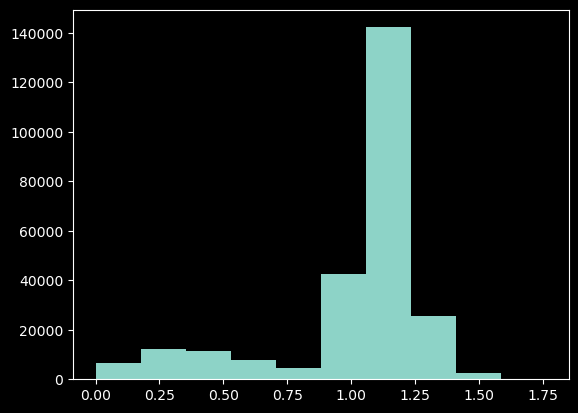

In [12]:
plt.hist(data = data, x = 'frac');

In [35]:
# Create a function that takes in the loss from the train_model as an argument
def loss_plot(loss, epochs):
    # Create a plot of the the epics and the losses for each epoch
    plt.plot(range(1, epochs + 1), loss);
    # Label the x-axis of the graph
    plt.xlabel("Epoch #");
    # Label the y-axis of the graph
    plt.ylabel("Cost");
    # Title the graph
    plt.title("Model Cost");
    # Show the plot inside of a function
    plt.show()

In [40]:
def tf_model(X_train, y_train, ep, b_s):
    # Initialize the model
    model = Sequential()

    # Create the first layer of the deep learning model with input set the number of features in X_train
    model.add(Dense(61, activation = 'relu', input_dim = X_train.shape[1]))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(53, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(38, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(25, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(14, activation = 'relu'))
    # Finish with the same amount of nodes as categories that there are to predict
    model.add(Dense(1, activation = 'linear'))
    # Compile the network with the standard optimiizer and loss function
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
    # Train the model with X_train and the encoded categorical y_group
    history = model.fit(X_train.astype('float32'), y_train, epochs = ep, batch_size = b_s)
    # Store the losses in a variable
    losses = history.history['loss']
    loss_plot(losses, int(ep))
    
    return model

Epoch 1/10
39/39 [==============================] - 2s 26ms/step - loss: 0.3487 - mean_absolute_error: 0.4669
Epoch 2/10
39/39 [==============================] - 1s 26ms/step - loss: 0.0841 - mean_absolute_error: 0.2170
Epoch 3/10
39/39 [==============================] - 1s 26ms/step - loss: 0.0709 - mean_absolute_error: 0.1962
Epoch 4/10
39/39 [==============================] - 1s 16ms/step - loss: 0.0637 - mean_absolute_error: 0.1803
Epoch 5/10
39/39 [==============================] - 1s 22ms/step - loss: 0.0581 - mean_absolute_error: 0.1653
Epoch 6/10
39/39 [==============================] - 1s 17ms/step - loss: 0.0541 - mean_absolute_error: 0.1541
Epoch 7/10
39/39 [==============================] - 1s 17ms/step - loss: 0.0514 - mean_absolute_error: 0.1456
Epoch 8/10
39/39 [==============================] - 1s 23ms/step - loss: 0.0494 - mean_absolute_error: 0.1398
Epoch 9/10
39/39 [==============================] - 1s 25ms/step - loss: 0.0481 - mean_absolute_error: 0.1362
Epoch 10/1

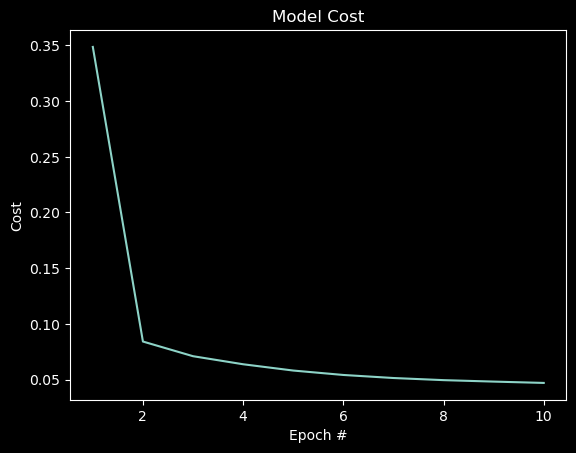

In [41]:
tf_model(X_train, y_train, 10, 5000)

Fold 1/5
Epoch 1/5
31/31 [==============================] - 2s 26ms/step - loss: 0.6725 - mean_absolute_error: 0.7162
Epoch 2/5
31/31 [==============================] - 1s 20ms/step - loss: 0.1239 - mean_absolute_error: 0.2643
Epoch 3/5
31/31 [==============================] - 1s 26ms/step - loss: 0.0823 - mean_absolute_error: 0.2120
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 0.0751 - mean_absolute_error: 0.2011
Epoch 5/5
31/31 [==============================] - 1s 24ms/step - loss: 0.0706 - mean_absolute_error: 0.1944


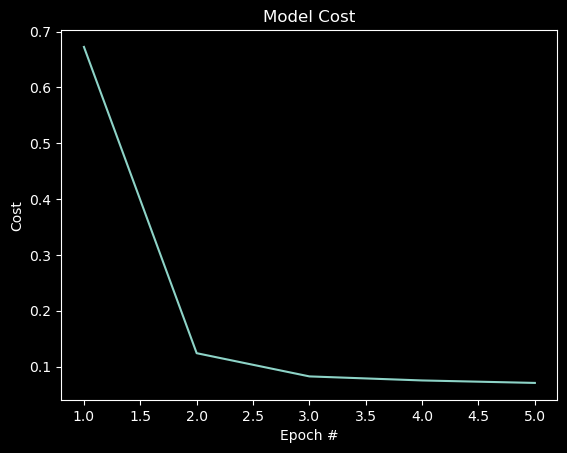

1199/1199 [==============================] - 2s 1ms/step
Train MSE: 0.0683 - Validation MSE: 0.0686

Fold 2/5
Epoch 1/5
31/31 [==============================] - 1s 12ms/step - loss: 0.4101 - mean_absolute_error: 0.5180
Epoch 2/5
31/31 [==============================] - 0s 10ms/step - loss: 0.0917 - mean_absolute_error: 0.2290
Epoch 3/5
31/31 [==============================] - 0s 13ms/step - loss: 0.0767 - mean_absolute_error: 0.2056
Epoch 4/5
31/31 [==============================] - 0s 13ms/step - loss: 0.0711 - mean_absolute_error: 0.1954
Epoch 5/5
31/31 [==============================] - 0s 15ms/step - loss: 0.0658 - mean_absolute_error: 0.1848


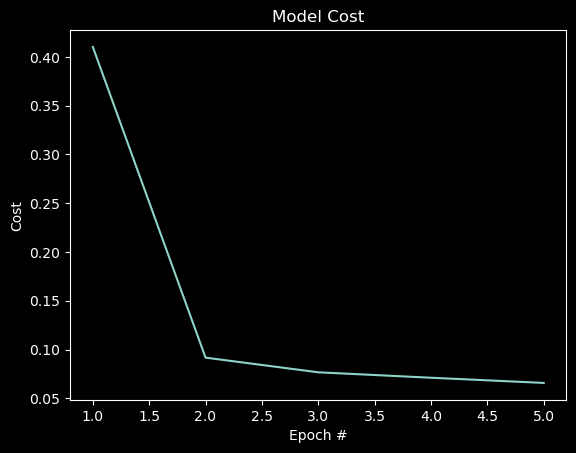

1199/1199 [==============================] - 2s 1ms/step
Train MSE: 0.0631 - Validation MSE: 0.0628

Fold 3/5
Epoch 1/5
31/31 [==============================] - 3s 52ms/step - loss: 0.3458 - mean_absolute_error: 0.4690
Epoch 2/5
31/31 [==============================] - 1s 49ms/step - loss: 0.0896 - mean_absolute_error: 0.2284
Epoch 3/5
31/31 [==============================] - 1s 41ms/step - loss: 0.0754 - mean_absolute_error: 0.2012
Epoch 4/5
31/31 [==============================] - 1s 37ms/step - loss: 0.0708 - mean_absolute_error: 0.1938
Epoch 5/5
31/31 [==============================] - 2s 54ms/step - loss: 0.0663 - mean_absolute_error: 0.1842


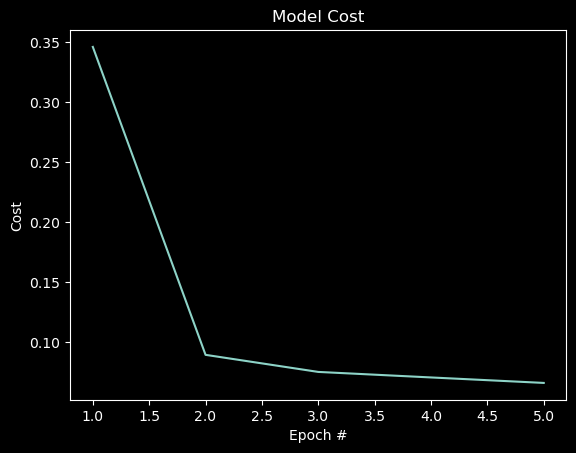

1199/1199 [==============================] - 2s 1ms/step
Train MSE: 0.0635 - Validation MSE: 0.0636

Fold 4/5
Epoch 1/5
31/31 [==============================] - 2s 25ms/step - loss: 0.3468 - mean_absolute_error: 0.4669
Epoch 2/5
31/31 [==============================] - 1s 21ms/step - loss: 0.0884 - mean_absolute_error: 0.2252
Epoch 3/5
31/31 [==============================] - 1s 23ms/step - loss: 0.0761 - mean_absolute_error: 0.2029
Epoch 4/5
31/31 [==============================] - 1s 27ms/step - loss: 0.0713 - mean_absolute_error: 0.1946
Epoch 5/5
31/31 [==============================] - 1s 17ms/step - loss: 0.0664 - mean_absolute_error: 0.1846


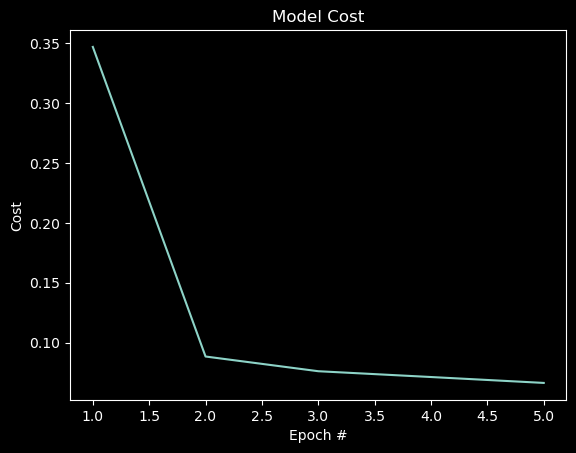

1199/1199 [==============================] - 2s 1ms/step
Train MSE: 0.0635 - Validation MSE: 0.0658

Fold 5/5
Epoch 1/5
31/31 [==============================] - 1s 15ms/step - loss: 0.6078 - mean_absolute_error: 0.6717
Epoch 2/5
31/31 [==============================] - 0s 16ms/step - loss: 0.1114 - mean_absolute_error: 0.2538
Epoch 3/5
31/31 [==============================] - 1s 25ms/step - loss: 0.0801 - mean_absolute_error: 0.2075
Epoch 4/5
31/31 [==============================] - 0s 14ms/step - loss: 0.0741 - mean_absolute_error: 0.1998
Epoch 5/5
31/31 [==============================] - 1s 24ms/step - loss: 0.0702 - mean_absolute_error: 0.1934


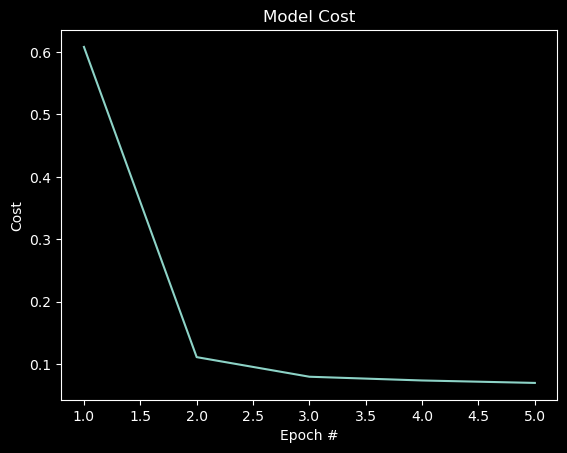

1199/1199 [==============================] - 2s 1ms/step
Train MSE: 0.0682 - Validation MSE: 0.0684

Average Validation MSE: 0.0658


In [49]:
# Assuming X_train and y_train are Pandas DataFrames
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Set the number of folds
num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Create lists to store training and validation MSE for each fold
train_mse_list = []
val_mse_list = []

# Convert DataFrames to NumPy arrays
X_train_values = X_train.values
y_train_values = y_train.values

# Iterate over folds
for fold, (train_index, val_index) in enumerate(kf.split(X_train_values)):
    print(f"Fold {fold + 1}/{num_folds}")
    
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_values[train_index], X_train_values[val_index]
    y_train_fold, y_val_fold = y_train_values[train_index], y_train_values[val_index]
    
    # Create the model
    model = tf_model(X_train_fold, y_train_fold, 5, 5000)
    
    # Evaluate the model on training and validation sets
    train_preds = model.predict(X_train_fold)
    val_preds = model.predict(X_val_fold)
    
    train_mse = mean_squared_error(y_train_fold, train_preds)
    val_mse = mean_squared_error(y_val_fold, val_preds)
    
    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)
    
    print(f"Train MSE: {train_mse:.4f} - Validation MSE: {val_mse:.4f}\n")

# Calculate the average validation MSE across all folds
avg_val_mse = np.mean(val_mse_list)
print(f"Average Validation MSE: {avg_val_mse:.4f}")


In [ ]:
# Initialize a random forest model
rf = RandomForestClassifier(n_jobs = 4)
# Create a set of values to search
param_grid = {'n_estimators': [5, 50, 100, 150, 200, 300, 600]}  
# Create the grid search object with 5 cross validational folds
grid_search = GridSearchCV(rf, param_grid, cv = 2, verbose = 1)  
# Fit the data to the grid search
grid_search.fit(X, y_train)
# Save the best parameters  
best_params = grid_search.best_params_
# Print the best parameters
best_params